In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import numpy as np
import metpy.calc as mpcalc
import matplotlib.pyplot as plt
import matplotlib.colors as col

from py3grads import Grads as GrADS
from datetime import datetime, timedelta
from metpy.units import units
from metpy.plots import colortables, USCOUNTIES

In [2]:
# Model parameters
model='hrrr'
runTime=datetime(2020, 6, 2, 18)
numOfFrames=6

# Map parameters
domain=[-81.87, -71.87, 40.5, 45.5]
plotCities=True

In [3]:
def getDataURL(model, runTime):
    if 'nam' in model:
        return f'http://nomads.ncep.noaa.gov/dods/nam/nam{runTime.strftime("%Y%m%d")}/{model}_{runTime.strftime("%Hz")}'
    elif 'hrrr' in model:
        return f'http://nomads.ncep.noaa.gov/dods/hrrr/hrrr{runTime.strftime("%Y%m%d")}/{model}_sfc.t{runTime.strftime("%Hz")}'
    elif 'hiresw' in model:
        return f'http://nomads.ncep.noaa.gov/dods/hiresw/hiresw{runTime.strftime("%Y%m%d")}/{model}_{runTime.strftime("%Hz")}'
    elif 'gfs' in model:
        return f'http://nomads.ncep.noaa.gov/dods/model/gfs{runTime.strftime("%Y%m%d")}/{model}_{runTime.strftime("%Hz")}'
    elif 'rap' in model:
        return f'http://nomads.ncep.noaa.gov/dods/rap/rap{runTime.strftime("%Y%m%d")}/{model}_{runTime.strftime("%Hz")}'  
    return None 

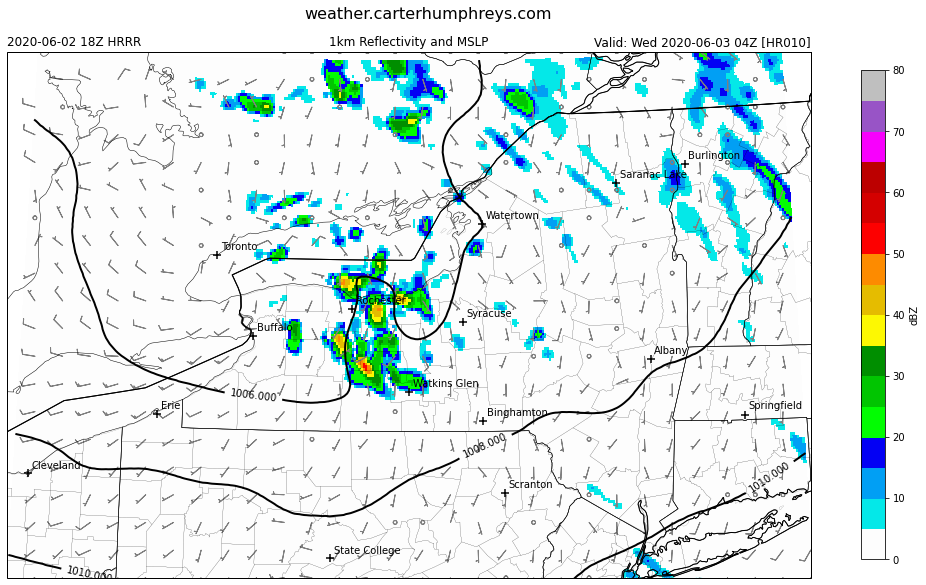

In [4]:
# Start GrADS
ga = GrADS(verbose=False)

# Load model data from NOMADS server
dataURL = getDataURL(model, runTime)
ga(f'sdfopen {dataURL}')

# Set location
ga(f'set lat {domain[2]} {domain[3]}')
ga(f'set lon {domain[0]} {domain[1]}')

for frame in range(numOfFrames):
    frame+=10
    
    # Set Time
    validTime = runTime + timedelta(hours=frame)
    ga(f'set time {validTime.strftime("%HZ%d%b%Y")}')
    
    # Get Data
    lat=ga.exp('lat')
    lon=ga.exp('lon')
    refd1000m=ga.exp('refd1000m')
    mslmamsl=ga.exp('mslmamsl') / 100
    ugrd10m=ga.exp('ugrd10m') * 1.944
    vgrd10m=ga.exp('vgrd10m') * 1.944
    
    # set up the figure
    fig = plt.figure(figsize=(18, 10))

    # Generate an Cartopy projection
    domain=[-81.87, -71.87, 40.5, 45.5]
    crs=ccrs.PlateCarree()
    proj = ccrs.Stereographic(central_longitude=(domain[1]-domain[0])/2+domain[0], central_latitude=(domain[3]-domain[2])/2+domain[2])
    ax = fig.add_subplot(1, 1, 1, projection=proj)
    ax.set_extent(domain, crs=crs)

    # plot the field using the fast pcolormesh routine
    cmap = col.ListedColormap(['#fdfdfd', '#04e8e8','#019ff4', '#0300f4', '#02fd02', '#01c501', '#008e00', '#fdf802', '#e5bc00', 
                               '#fd8b00', '#fd0000', '#d40000', '#bc0000', '#f800fd', '#9854c6', '#bfbfbf'])   
    norm = col.BoundaryNorm(range(0, 85, 5), cmap.N)
    data=plt.pcolormesh(lon, lat, refd1000m, cmap=cmap, norm=norm, transform=crs)
    plt.colorbar(data, ax=ax, shrink=0.9, label='dBZ')
    
    # Plot wind barbs
    ax.barbs(lon, lat, ugrd10m, vgrd10m, length=5, regrid_shape=20, transform=crs, color='tab:gray')

    # Plot MSLP contour
    isobars=plt.contour(lon, lat, mslmamsl, transform=crs, levels=range(950, 1080, 2), colors='k', linewidths=2)
    plt.clabel(isobars, isobars.levels, inline=True, fontsize=10)

    # Add geographic features
    country_borders=cfeature.NaturalEarthFeature(category='cultural', name='admin_0_countries', scale='10m', facecolor='none')
    ax.add_feature(country_borders, edgecolor='black', linewidth=1.0)
    state_borders=cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lakes', scale='10m', facecolor='none')
    ax.add_feature(state_borders, edgecolor='black', linewidth=0.5)
    ax.add_feature(USCOUNTIES.with_scale('5m'), edgecolor='black', linewidth=0.1)

    # Add Places
    if plotCities:
        cities=[{'Name':'Watkins Glen', 'Lat':42.38, 'Lon':-76.87}, {'Name':'Binghamton', 'Lat':42.10, 'Lon':-75.92}, 
                {'Name':'Syracuse', 'Lat':43.04, 'Lon':-76.17}, {'Name':'Rochester', 'Lat':43.16, 'Lon':-77.61}, 
                {'Name':'Albany', 'Lat':42.65, 'Lon':-73.76}, {'Name':'Saranac Lake', 'Lat':44.33, 'Lon':-74.13}, 
                {'Name':'Watertown', 'Lat':43.97, 'Lon':-75.91}, {'Name':'Buffalo', 'Lat':42.89, 'Lon':-78.88},
                {'Name':'Toronto', 'Lat':43.65, 'Lon':-79.38}, {'Name':'Cleveland', 'Lat':41.50, 'Lon':-81.69},
                {'Name':'Scranton', 'Lat':41.41, 'Lon':-75.66}, {'Name':'Erie', 'Lat':42.12, 'Lon':-80.09}, 
                {'Name':'Springfield', 'Lat':42.08, 'Lon':-72.59}, {'Name':'Burlington', 'Lat':44.48, 'Lon':-73.21}, 
                {'Name':'State College', 'Lat':40.79, 'Lon':-77.86}]

        for city in cities:
            ax.scatter(city['Lon'], city['Lat'], marker='+', c='k', s=50, transform=ccrs.Geodetic())
            ax.text(city['Lon']+0.05, city['Lat']+0.05, city['Name'], transform=ccrs.Geodetic())

    # Add Headers
    plt.title(f'{runTime.strftime("%Y-%m-%d %H")}Z {model.upper()}', loc='left')
    plt.title(f'1km Reflectivity and MSLP', loc='center')
    plt.title(f'Valid: {validTime.strftime("%a %Y-%m-%d %H")}Z [HR{str(frame).zfill(3)}]', loc='right')

    # Add citation
    plt.suptitle(f'weather.carterhumphreys.com', fontsize=16, x=0.45, y=0.93)

    plt.show()
    break